In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
devie = torch.device("mps")

In [2]:
from models.FireDetectionModelFactory import FireDetectionModelFactory

model_name = "resnet50"
to_train = 5
num_classes = 1

model = FireDetectionModelFactory.create_model(model_name, num_classes, to_train)
model

Using cache found in /Users/cristian/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/cristian/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cristian/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [3]:
import torch
from torchvision import transforms
import albumentations

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])


augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30)
    ])

# Dataset

In [4]:
# Metti qua il tuo path al dataset
path = "../data/IMAGE_DATASET/Train/"

In [5]:
import os 

# define function that walks through each directory and subdirectory
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(path)

There are 2 directories and 1 images in '../data/IMAGE_DATASET/Train/'.
There are 0 directories and 900 images in '../data/IMAGE_DATASET/Train/0'.
There are 0 directories and 7632 images in '../data/IMAGE_DATASET/Train/1'.


In [6]:
from pathlib import Path
#setup path for our data files
fire_dir = Path(path+"/1")
non_fire_dir = Path(path+"/0")

fire_dir, non_fire_dir


(PosixPath('../data/IMAGE_DATASET/Train/1'),
 PosixPath('../data/IMAGE_DATASET/Train/0'))

In [7]:
from torchvision.datasets import ImageFolder

#define data root directory
root_dir = path

#you can also apply data transformation using the `transforms` parameter here
fire_dataset = ImageFolder(root_dir, transform=transforms.Compose([preprocess, augmentation]))

In [8]:
#the classes are the names of the files in the root folder
class_names = fire_dataset.classes
class_names

['0', '1']

In [9]:
#class names as a dict
class_dict = fire_dataset.class_to_idx
class_dict

{'0': 0, '1': 1}

In [10]:
from torch.utils.data import random_split
# split the dataset into training, validation and testing
rand_bytes = os.urandom(8) # generate 8 random bytes (64 bits) beacuse manual_seed needs a 64-bit integer (8 bytes)
rand_int = int.from_bytes(rand_bytes, byteorder='big')
train_dataset, valid_dataset, test_dataset = random_split(fire_dataset, [0.75, 0.15, 0.10], generator=torch.Generator().manual_seed(rand_int))

In [11]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6399, 1279, 853)

# Training

In [12]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import os

def start_tensorboard(log_dir):
  writer = SummaryWriter(os.path.join("runs", log_dir))

  # run tensorboard in background
  ! killall tensorboard
  %load_ext tensorboard
  %tensorboard --logdir ./runs

  notebook.list() # View open TensorBoard instances

  return writer

In [13]:
from torchvision.utils import make_grid
from tqdm import tqdm

def one_epoch(model, lossFunction, output_activation, optimizer, train_loader, val_loader, writer, epoch_num):
  model.to(device)

  model.train()

  i_start = epoch_num * len(train_loader)
  for i, (X, y) in tqdm(enumerate(train_loader), desc="epoch {} - train".format(epoch_num)):
    if i == 0:
      writer.add_image('first_batch', make_grid(X))

    X = X.to(device)
    y = y.to(device).float()

    optimizer.zero_grad()

    o = model(X)
    o = output_activation(o).squeeze()
    l = lossFunction(o, y)


    l.backward()
    optimizer.step()

    acc = ((o.detach() > .5) == y.detach()).float().mean()
    
    # print("- batch loss and accuracy : {:.7f}\t{:.4f}".format(l.detach().item(), acc))
    writer.add_scalar('train/loss', l.detach().item(), i_start+i)
    writer.add_scalar('train/acc', acc, i_start+i)

  model.eval()
  with torch.no_grad():
    val_loss = []
    val_corr_pred = []
    for X, y in tqdm(val_loader, desc="epoch {} - validation".format(epoch_num)):
      X = X.to(device)
      y = y.to(device).float()

      o = model(X)
      o = output_activation(o).squeeze()
      val_loss.append(lossFunction(o, y))
      val_corr_pred.append((o > .5) == y)

    val_loss = torch.stack(val_loss).mean().item()
    val_accuracy = torch.concatenate(val_corr_pred).float().mean().item()

    # print("Validation loss and accuracy : {:.7f}\t{:.4f}".format(val_loss, val_accuracy))
    writer.add_scalar('val/loss', val_loss, i_start+i)
    writer.add_scalar('val/acc', val_accuracy, i_start+i)
  return val_loss, val_accuracy

In [14]:
from torch.nn import BCELoss, CrossEntropyLoss, Sigmoid, Softmax
from datetime import datetime

# learning parameters
lossFunction, output_activation = BCELoss(), Sigmoid()
batch_size = 84
lr = .00001
momentum = .9
lambda_reg = 0

epochs = 300
early_stopping_patience = 5

optimizer = torch.optim.Adam(model.get_trainable_parameters(),
                          lr=lr,
                          weight_decay=lambda_reg)

# create output directory and logger
name = model_name+"_"+datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_name = os.path.join("experiments", name)

import os
#!rm -rf resnet18_images
os.makedirs(experiment_name)
writer = start_tensorboard(experiment_name)

No matching processes belonging to you were found


Known TensorBoard instances:
  - port 6006: logdir ./runs (started 0:00:00 ago; pid 971)


In [15]:
from torch.utils.data import DataLoader
dataloader_params = {"batch_size": batch_size, "num_workers": 2, "pin_memory": True}
train_loader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
val_loader = DataLoader(valid_dataset, shuffle=False, **dataloader_params)

# early stopping and best model saving
early_stopping_counter = early_stopping_patience
min_val_loss = 1e10

# training and validation
val_losses = torch.zeros(epochs)
val_accuracies = torch.zeros(epochs)
for e in range(epochs):
  print("EPOCH {}".format(e))
  val_loss, val_accuracy = one_epoch(model, lossFunction, output_activation, optimizer, train_loader, val_loader, writer, e)

  # store the validation metrics
  val_losses[e] = val_loss
  val_accuracies[e] = val_accuracy
  torch.save(val_losses, os.path.join(experiment_name,'val_losses.pth'))
  torch.save(val_accuracies, os.path.join(experiment_name,'val_accuracies.pth'))

  # save the best model and check the early stopping criteria
  if val_loss < min_val_loss: # save the best model
    min_val_loss = val_loss
    early_stopping_counter = early_stopping_patience # reset early stopping counter
    torch.save(model.state_dict(), os.path.join(experiment_name,'best_model.pth'))
    print("- saved best model: val_loss =", val_loss, "val_accuracy =", val_accuracy)

  if e>0: # early stopping counter update
    if val_losses[e] > val_losses[e-1]:
        early_stopping_counter -= 1 # update early stopping counter
    else:
        early_stopping_counter = early_stopping_patience # reset early stopping counter
  if early_stopping_counter == 0: # early stopping
      break

EPOCH 0


epoch 0 - train: 77it [1:37:31, 75.99s/it] 
epoch 0 - validation: 100%|██████████| 16/16 [01:53<00:00,  7.09s/it]


- saved best model: val_loss = 0.22079665958881378 val_accuracy = 0.974198579788208
EPOCH 1


epoch 1 - train: 77it [1:47:31, 83.79s/it] 
epoch 1 - validation: 100%|██████████| 16/16 [01:48<00:00,  6.80s/it]

- saved best model: val_loss = 0.07720894366502762 val_accuracy = 0.9874902367591858
EPOCH 2



epoch 2 - train: 0it [00:08, ?it/s]


KeyboardInterrupt: 

# Testing

In [16]:
from torch.utils.data import DataLoader
dataloader_params = {"batch_size": batch_size, "num_workers": 2, "pin_memory": True}
test_loader = DataLoader(test_dataset, shuffle=False, **dataloader_params)

model = FireDetectionModelFactory.create_model(model_name, num_classes, to_train)
model.load_state_dict(torch.load(os.path.join(experiment_name,'best_model.pth')))

Y, Y_hat = [], []
with torch.no_grad():
  model.eval()
  for X, y in test_loader:
    Y.append(y)
    Y_hat.append((output_activation(model(X.to(device))) > .5).squeeze().to(device))

Y = torch.concatenate(Y).to("cpu")
Y_hat = torch.concatenate(Y_hat).to("cpu")
print("Test accuracy:", (Y==Y_hat).float().mean().item())


Using cache found in /Users/cristian/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/cristian/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cristian/opt/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test accuracy: 0.9882766604423523


In [17]:
from sklearn.metrics import confusion_matrix
# Compute precision and recall and F-score
from sklearn.metrics import precision_score, recall_score

confusion_matrix(Y, Y_hat)

precision = precision_score(Y, Y_hat)
recall = recall_score(Y, Y_hat)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F-score: {:.4f}".format(2 * precision * recall / (precision + recall)))

Precision: 0.9922
Recall: 0.9948
F-score: 0.9935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


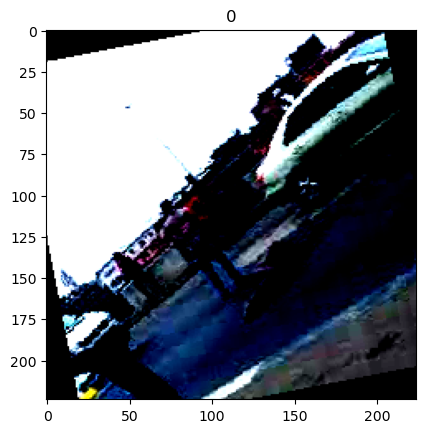

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


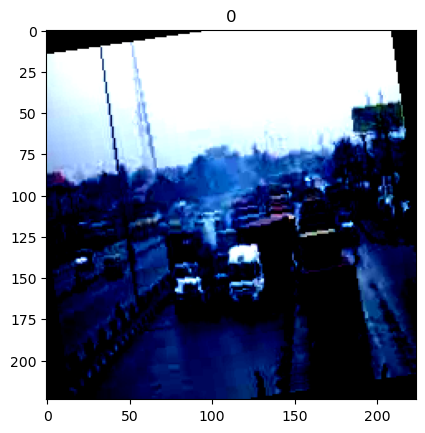

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


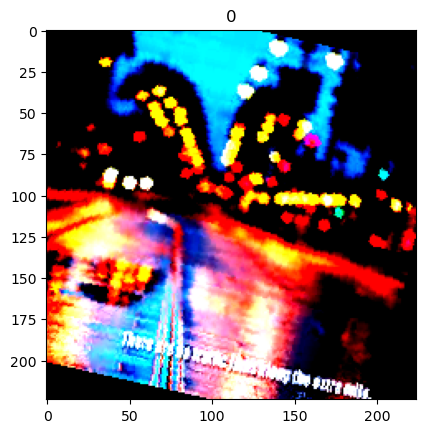

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


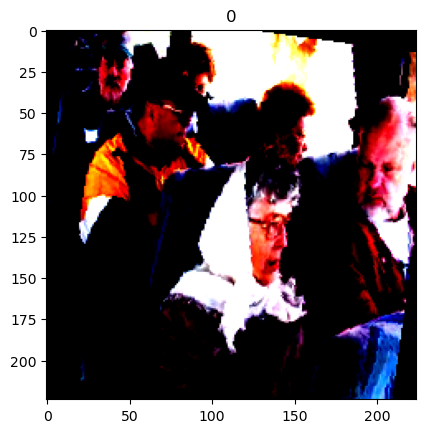

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


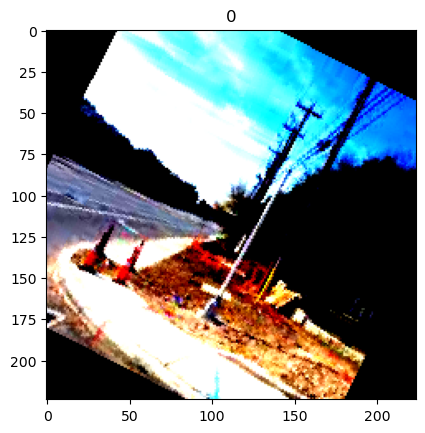

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


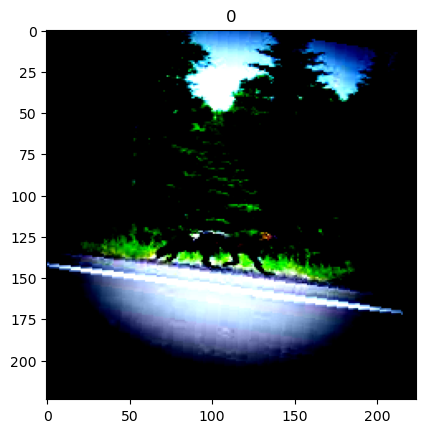

In [18]:
import matplotlib.pyplot as plt

def visualize_video_sample(X, y):
    plt.figure()
    plt.imshow(make_grid(X).numpy().transpose((1, 2, 0)))
    plt.title(y)
    plt.show()

# analyze the false positives

for i in range(len(Y)):
  if Y[i] == 0 and Y_hat[i] == 1:
    visualize_video_sample(test_dataset[i][0], test_dataset[i][1])